In [1]:
import pandas as pd

pd.set_option("display.max_rows", 999)
pd.set_option("display.max_columns", 999)
pd.set_option('display.max_rows', 999)
pd.set_option('display.min_rows', 999)

%config IPCompleter.use_jedi = False

# Load Data From Cornell Data Set
The data come from here: https://pad.human.cornell.edu/schools/datadownload.cfm.  Below, we do the following:
* lowercase all of column names
* choose the 'All Students' subgroups (because the other subgroup membership isn't consistent)
* change data types on grad to integer
* truncate year in grad to always be the same length. 
* NOTE: All of these are intact as downloaded except, although you may have to play around with loading data on tabs vs spaces.

# Merge the data Sets
Then following that, we do the following:

* merge graduation + demographcis on district code * year (this yields multiple cohorts per year & district)
* write to .csv for safe keeping

In [2]:
%%time 
grad = pd.read_csv('../data/graduation_all.csv')
grad.columns = grad.columns.str.lower()
grad['year'] = grad.srcyear.astype(str).str[:4]
grad = grad[grad.subgroup == 1.0]
grad.year = grad.year.astype('int')
display(grad.shape)

apm = pd.read_csv("../data/apm_all.csv")
apm.columns = apm.columns.str.lower()
apm = apm[apm.subgroup == 1]

demo = pd.read_csv('../data/Demographics_all.csv')
demo.columns = demo.columns.str.lower()

faru = pd.read_csv("../data/FARU_all.csv")
faru.columns = faru.columns.str.lower()

basicinfo = pd.read_csv("../data/BasicInfo.csv")
basicinfo.columns = basicinfo.columns.str.lower()
basicinfo["district_name"] = basicinfo.district_name.str.lower()
basicinfo['name'] = basicinfo["district_name"].str.replace(" sd", "")
basicinfo['name'] = basicinfo["name"].str.replace(" csd", " central")
basicinfo['name'] = basicinfo["name"].str.replace(" ufsd", "")

(32256, 14)

CPU times: user 838 ms, sys: 146 ms, total: 985 ms
Wall time: 1 s


In [3]:
df1 = pd.merge(grad, demo, 
               how='inner', 
               left_on=["district_cd", "year"], 
               right_on=["district", "year"], 
               suffixes=["_from_grad", "_from_demo"])

df = pd.merge(df1, faru, 
              how='inner', 
              left_on=["district_cd", "year"], 
              right_on=["district", "year"],
              suffixes=["_from_df1", "_from_faru"])

df.to_csv("../data/apm_demo_faru_grad_clean.csv")

# County Join
Here we have to do some pandas gymnastics as we clean up the data enough to join counties to the data set. Here's what we are doing:
1. load the NYSED data set (https://data.nysed.gov/downloads.php) into df_combined
2. clean it up and filter for district level aggregation and subgroup_code = 1
3. load the district to name county mapping and clean up
4. merge the data and save to csv


In [4]:
county_coverage = pd.read_table("../data/36_County_Coverage_A.txt", sep="[ ]{2,}", header=0, engine = 'python')
county_coverage['district_name'] = county_coverage.name.str.lower()
cc = county_coverage[["county_name", "district_name"]]
display(cc.head())
display(cc.dtypes)
display(cc.district_name.nunique())

b = basicinfo[["districtid", "name"]]

,county_name,district_name
0,Albany,rotterdam-mohonasen central
1,Albany,north colonie central
2,Albany,albany city
3,Albany,berne-knox-westerlo central
4,Albany,bethlehem central


county_name      object
district_name    object
dtype: object

682

In [5]:
map1 = pd.merge(b, cc, how="inner", left_on="name", right_on="district_name")
display(map1.head())
display(map1.shape)

,districtid,name,county_name,district_name
0,10100,albany city,Albany,albany city
1,10201,berne-knox-westerlo central,Albany,berne-knox-westerlo central
2,10201,berne-knox-westerlo central,Schoharie,berne-knox-westerlo central
3,10306,bethlehem central,Albany,bethlehem central
4,10402,ravena-coeymans-selkirk central,Albany,ravena-coeymans-selkirk central


(804, 4)

In [10]:
df_with_counties = pd.merge(df, map1,
                           how='left',
                           left_on='district_cd',
                           right_on='districtid',
                           suffixes=['_from_df', '_from_map'])

In [11]:
df_with_counties.to_csv("../data/df_with_counties_v1.csv")

# Clean NAs


In [12]:
df = pd.read_csv("../data/df_with_counties_v1.csv")

In [13]:
# drop all cols with huge percent of NA (in the 1e5 range) - drop these columns
display(df.columns[(df.isna().sum() > 10000).values])
df_col_clean = df.drop(columns=df.columns[(df.isna().sum() > 10000).values])

# now all the na's between 0 and 10000 (drop these rows)
display(df_col_clean.columns[(df_col_clean.isna().sum() > 0).values])
df_row_clean = df_col_clean.dropna(axis = 0, subset = ['county_name']) # 6000 or so rows that can't be used

Index(['_name_', 'gr_local_cnt', 'num_female', 'num_male', 'num_swd',
       'num_ecdis', 'num_ell'],
      dtype='object')

Index(['num_asian', 'num_black', 'num_hisp', 'num_am_ind', 'num_white',
       'num_multi', 'districtid', 'name', 'county_name', 'district_name'],
      dtype='object')

# Impute Missing Values

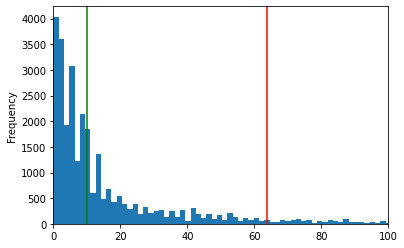

In [14]:
import matplotlib.pyplot as plt

df_row_clean.num_asian.plot(kind='hist', 
                            bins=2000, 
                            xlim=(0, 100))
plt.axvline(df_row_clean.num_asian.mean(), color='red')
plt.axvline(df_row_clean.num_asian.median(), color='green')

In [19]:
race_impute = df_row_clean[['num_asian', 
                           'num_black', 
                           'num_hisp', 
                           'num_multi']].fillna(df_row_clean[['num_asian', 
                                                              'num_black', 
                                                              'num_hisp', 
                                                              'num_multi']].median())


In [20]:


# replace imputed race columns into df_row_clean
df_row_clean = df_row_clean.assign(num_asian = race_impute["num_asian"])
df_row_clean = df_row_clean.assign(num_black = race_impute["num_black"])
df_row_clean = df_row_clean.assign(num_hisp = race_impute["num_hisp"])
df_row_clean = df_row_clean.assign(num_multi = race_impute["num_multi"])



In [ ]:
df_final.to_csv('./df_clean_unreg.csv')

In [22]:
df_row_clean.shape

(32632, 83)